Same as generating-CWRNN. More details there.

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from clockwork.cwrnn import CWRNNCell

batch_size = 1
seq_len = 1
num_components = 3

NHIDDEN = 256
NCELLS = 8

inputs = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, num_components])
targets = tf.placeholder(dtype=tf.float32, shape=[batch_size, seq_len, num_components])

#CWRNN Part
#cells = []
#for i in range(NCELLS):
#    cells.append(tf.contrib.rnn.BasicRNNCell(num_units=NHIDDEN//NCELLS))
#
#periods = []
#for i in range(NCELLS):
#    periods.append(2**i)
#
#cell = CWRNNCell(cells, periods, state_is_tuple=False)

#LSTM Part
cell = tf.contrib.rnn.BasicLSTMCell(NHIDDEN, state_is_tuple=False)

cell = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.BasicLSTMCell(NHIDDEN, state_is_tuple=False) for _ in range(2)],
            state_is_tuple=False
)

#cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = 0.8)

zero_state = cell.zero_state(batch_size=batch_size, dtype=tf.float32)
prev_state = tf.identity(zero_state, name='prev_state')

NOUT = 1 + 20 * 6 # end_of_stroke + prob + 2*(mu + sig) + corr

with tf.variable_scope('rnnlm'):
    output_w = tf.get_variable("output_w", [NHIDDEN, NOUT])
    output_b = tf.get_variable("output_b", [NOUT])
    
inputs2 = tf.unstack(inputs, axis=1)

#Forward pass
outputs, state_out = tf.contrib.legacy_seq2seq.rnn_decoder(inputs2, prev_state, cell, loop_function=None, scope='rnnlm')
output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, NHIDDEN])
output = tf.nn.xw_plus_b(output, output_w, output_b)
state_out = tf.identity(state_out, name='state_out')

#Some trying

#outputs, _ = tf.contrib.legacy_seq2seq.rnn_decoder(cell=cell, decoder_inputs=x, initial_state=zero_state)
#outputs, out_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=prev_state, time_major=False)

#NOUT = 1 + 20 * 6 # end_of_stroke + prob + 2*(mu + sig) + corr

#W_out = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=1.0, dtype=tf.float32))
#b_out = tf.Variable(tf.random_normal([NOUT], stddev=1.0, dtype=tf.float32))

#output = tf.reshape(outputs, [-1, NHIDDEN])
#output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, NHIDDEN])
#print(output.shape)
#output = tf.nn.xw_plus_b(output, W_out, b_out)

#End of some trying


flat_targets = tf.reshape(targets, [-1, num_components])
[x1_data, x2_data, eos_data] = tf.split(axis=1, num_or_size_splits=3, value=flat_targets)

#MDN Part. Mainly copied from https://github.com/hardmaru/write-rnn-tensorflow.
def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
    # eq # 24 and 25 of http://arxiv.org/abs/1308.0850
    norm1 = tf.subtract(x1, mu1)
    norm2 = tf.subtract(x2, mu2)
    s1s2 = tf.multiply(s1, s2)
    z = tf.square(tf.div(norm1, s1))+tf.square(tf.div(norm2, s2))-2*tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
    negRho = 1-tf.square(rho)
    result = tf.exp(tf.div(-z,2*negRho))
    denom = 2*np.pi*tf.multiply(s1s2, tf.sqrt(negRho))
    result = tf.div(result, denom)
    return result

def get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos, x1_data, x2_data, eos_data):
    result0 = tf_2d_normal(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr)
    # implementing eq # 26 of http://arxiv.org/abs/1308.0850
    epsilon = 1e-20
    result1 = tf.multiply(result0, z_pi)
    result1 = tf.reduce_sum(result1, 1, keep_dims=True)
    result1 = -tf.log(tf.maximum(result1, 1e-20)) # at the beginning, some errors are exactly zero.

    result2 = tf.multiply(z_eos, eos_data) + tf.multiply(1-z_eos, 1-eos_data)
    result2 = -tf.log(result2)

    result = result1 + result2
    return tf.reduce_sum(result)

# below is where we need to do MDN splitting of distribution params
def get_mixture_coef(output):
    # returns the tf slices containing mdn dist params
    # ie, eq 18 -> 23 of http://arxiv.org/abs/1308.0850
    z = output
    z_eos = z[:, 0:1]
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(axis=1, num_or_size_splits=6, value=z[:, 1:])

    # process output z's into MDN paramters

    # end of stroke signal
    z_eos = tf.sigmoid(z_eos) # should be negated, but doesn't matter.

    # softmax all the pi's:
    max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
    z_pi = tf.subtract(z_pi, max_pi)
    z_pi = tf.exp(z_pi)
    normalize_pi = tf.reciprocal(tf.reduce_sum(z_pi, 1, keep_dims=True))
    z_pi = tf.multiply(normalize_pi, z_pi)

    # exponentiate the sigmas and also make corr between -1 and 1.
    z_sigma1 = tf.exp(z_sigma1)
    z_sigma2 = tf.exp(z_sigma2)
    z_corr = tf.tanh(z_corr)

    return [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos]

#Get distribution parameters from network output
[o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos] = get_mixture_coef(output)

#Parameters for outputs
data_out_pi = tf.identity(o_pi, "data_out_pi");
data_out_mu1 = tf.identity(o_mu1, "data_out_mu1");
data_out_mu2 = tf.identity(o_mu2, "data_out_mu2");
data_out_sigma1 = tf.identity(o_sigma1, "data_out_sigma1");
data_out_sigma2 = tf.identity(o_sigma2, "data_out_sigma2");
data_out_corr = tf.identity(o_corr, "data_out_corr");
data_out_eos = tf.identity(o_eos, "data_out_eos");

#Loss Function
lossfunc = get_lossfunc(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, x1_data, x2_data, eos_data)
cost = lossfunc / (batch_size * seq_len)

#Train network with AdamOptimizer and desired learninig rate with gradient clippingg
lr = tf.Variable(0.0, trainable=False)
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 10.0)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.apply_gradients(zip(grads, tvars))

In [2]:
model_path = "./LSTM/"

def sample(sess, num=600):
    def get_pi_idx(x, pdf):
        N = pdf.size
        accumulate = 0
        for i in range(0, N):
            accumulate += pdf[i]
            if (accumulate >= x):
                return i
        print('error with sampling ensemble')
        print(accumulate)
        return -1

    def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
        mean = [mu1, mu2]
        cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
        x = np.random.multivariate_normal(mean, cov, 1)
        return x[0][0], x[0][1]

    prev_x = np.zeros((1, 1, num_components), dtype=np.float32)
    prev_x[0, 0, 2] = 1 # initially, we want to see beginning of new stroke
    ps = sess.run(cell.zero_state(1, tf.float32))

    strokes = np.zeros((num, 3), dtype=np.float32)
    mixture_params = []

    for i in range(num):

        feed = {inputs: prev_x, prev_state: ps}

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, next_state] = sess.run([data_out_pi, data_out_mu1, data_out_mu2, data_out_sigma1, data_out_sigma2, data_out_corr, data_out_eos, state_out],feed)

        idx = get_pi_idx(random.random(), o_pi[0])

        eos = 1 if random.random() < o_eos[0][0] else 0

        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx], o_sigma1[0][idx], o_sigma2[0][idx], o_corr[0][idx])

        strokes[i,:] = [next_x1, next_x2, eos]

        params = [o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0], o_eos[0]]
        mixture_params.append(params)

        prev_x = np.zeros((1, 1, 3), dtype=np.float32)
        prev_x[0][0] = np.array([next_x1, next_x2, eos], dtype=np.float32)
        ps = next_state

    strokes[:,0:2] *= 10
    return strokes, mixture_params

sess = tf.InteractiveSession()
#saver = tf.train.Saver(tf.all_variables())
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(model_path)
print("loading model: ", ckpt.model_checkpoint_path)
saver.restore(sess, ckpt.model_checkpoint_path)

loading model:  C:\Users\Jirka\Desktop\LSTM\model.ckpt-300
INFO:tensorflow:Restoring parameters from C:\Users\Jirka\Desktop\LSTM\model.ckpt-300


Run cell below to generate your own data.

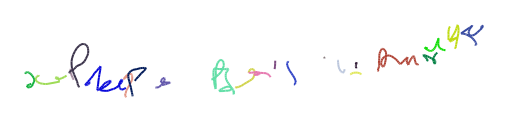

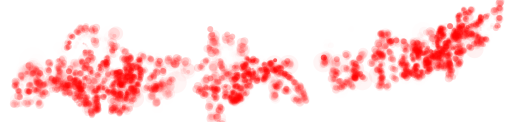

In [3]:
[strokes, params] = sample(sess, 700)
#draw_strokes(strokes, factor=10, svg_filename = "try"+'.normal.svg')
draw_strokes_random_color(strokes, factor=10, svg_filename = "try"+'.color.svg')
#draw_strokes_random_color(strokes, factor=10, per_stroke_mode = False, svg_filename = "try"+'.multi_color.svg')
#draw_strokes_eos_weighted(strokes, params, factor=10, svg_filename = "try"+'.eos_pdf.svg')
draw_strokes_pdf(strokes, params, factor=10, svg_filename = "try"+'.pdf.svg')